In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

In [2]:
data = pd.read_csv("data/unique_result.csv")
data = pd.DataFrame.transpose(data)
data = data.iloc[1:10][0]
data

prawo cywilne            ['remontowobudowlane', 'przedawnieniu', 'weksl...
prawo administracyjne    ['bankowych', 'budowlane', 'wywieszenie', 'nie...
prawo farmaceutyczne     ['dostępny', 'terenie', 'gifu', 'wzoru', 'iwyc...
prawo pracy              ['odprawy', 'zaległy', 'pracownicę', 'równoważ...
prawo medyczne           ['wyglądają', 'wyraził', 'ponad', 'najniższego...
prawo karne              ['płyty', 'pieniądze', 'dobrowolnej', 'zapobie...
prawo miädzynarodowe     ['udzielać', 'rękawice', 'już', 'bezpieczeństw...
prawo podatkowe          ['kwoty', 'leki', 'wstecz', 'fakturze', 'nacze...
prawo konstytucyjne       ['wyjść', 'powrocie', 'konstytucją', 'przepisy']
Name: 0, dtype: object

In [3]:
# data = []
# f = open('data/result-list.txt', 'r',encoding='utf-8')
# if f.mode=='r':
#     data= f.read()

Get Glove (https://github.com/sdadas/polish-nlp-resources#glove)

In [4]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format("data/glove_100_3_polish.txt")

def closest_word(in_vector, top_n=1):
    vectors = glove.values()
    idx = np.argsort([np.linalg.norm(vec-in_vector) for vec in vectors])
    return [glove.keys()[i] for i in idx[:top_n]]

In [5]:
def vectorize_tokens(tokens):
    words = [w for w in tokens if w is not None and w != ' ']
    return np.array([glove.get_vector(w) for w in words])

In [6]:
print(glove.get_vector('konstytucja'))

[-0.756483 -0.156726  0.240969 -0.108245 -0.722698  1.690118 -0.705028
  0.433565 -0.372361 -3.256995  0.735486  0.854555  0.436465 -0.219439
 -0.547062  1.285207 -0.759291 -0.464965 -0.765004  0.519478  0.802678
 -0.296283 -0.391004  0.378582  0.083068  0.993235  0.975976 -0.172345
  0.015326  0.765349 -0.026912 -0.568081 -0.66198   1.364534 -0.767949
 -0.720543 -0.431987 -0.019625  0.328186  0.521793 -0.622683  1.051005
  0.850165  0.334909  0.398969  0.261463  0.352421  0.007351  0.180869
 -0.192186  1.177872  0.17856   0.071584  0.06415  -0.454957  0.096224
  0.153221  0.043652  0.263161 -0.147932 -1.221667 -0.599179 -0.050714
  0.133675 -0.844797 -0.778254  0.562199 -0.181419  0.059016 -0.442529
 -0.131058 -1.192368  0.308126  0.305352  0.405265 -0.245622  0.763016
 -0.460105 -0.447609 -0.057151  0.187172 -0.199389  0.446935  0.138435
  0.425581 -0.280209 -0.129192 -0.39582  -0.262552 -0.046351  0.078262
  0.389644  0.554389  0.369812  0.240357  0.918529 -0.016188  0.635542
 -0.06

In [7]:
colors = OrderedDict({
    'prawo cywilne':'orange',
    'prawo administracyjne':'red',
    'prawo farmaceutyczne':'blue',
    'prawo pracy':'green',
    'prawo medyczne':'cyan',
    'prawo karne':'brown',
    'prawo miädzynarodowe':'black',
    'prawo podatkowe':'purple',
    'prawo konstytucyjne':'grey'
})
speechPartNames = list(colors.keys())
W = [vectorize_tokens(tokenized).mean(axis=0) for tokenized in data]
W = np.array(W)
W

array([[-2.24087648e-02,  1.03112427e-03,  3.06298435e-01,
        -6.53640702e-02, -9.71159220e-01, -4.55670178e-01,
        -5.29196300e-02,  4.98272151e-01, -7.96747655e-02,
        -4.21309900e+00,  2.49524713e-01, -3.49710912e-01,
         9.89779115e-01,  2.34580770e-01, -5.82184732e-01,
        -4.80777621e-01, -3.05441201e-01, -9.81344581e-02,
         1.91330574e-02,  1.56910880e-03,  4.55837667e-01,
        -8.87960419e-02,  1.33321553e-01,  2.10656933e-02,
         1.16288520e-01,  1.54066443e-01,  2.42456004e-01,
         3.35687101e-01,  3.75753313e-01, -2.48535164e-02,
        -1.66543156e-01,  8.50183442e-02,  5.08173048e-01,
         3.16382051e-01, -1.98580936e-01, -9.71845984e-02,
         3.37947130e-01,  2.01266378e-01, -2.08323151e-01,
         4.16171908e-01,  1.06156860e-02,  8.19421768e-01,
        -1.34436473e-01,  1.59561545e-01,  1.39100134e-01,
         1.16986372e-02, -5.49385607e-01,  5.93089342e-01,
        -2.95180470e-01, -4.27021652e-01,  4.80784416e-0

In [8]:
from minisom import MiniSom

In [9]:
map_dim = 20
som = MiniSom(map_dim, map_dim, 100, sigma=1.0, random_seed=1)
# som.random_weights_init(W)
som.train_batch(W, num_iteration=len(W)*500, verbose=True)

 [ 4500 / 4500 ] 100% - 0:00:00 left 
 quantization error: 1.0375550501487496e-05


c:\Users\1boze\AppData\Local\Programs\Python\Python39\lib\site-packages\minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


In [10]:
from string import punctuation
import stop_words
stopwords = stop_words.get_stop_words('polish')
def clearListFromUselessWords(words: list):
    for sign in punctuation:
        if sign in words:
            words.remove(sign)
    tokens = [t for t in words if t not in stopwords and t != '']
    return tokens

Did not find 1553/2136 words in the GloVe database, could not estimate it's vector


[]

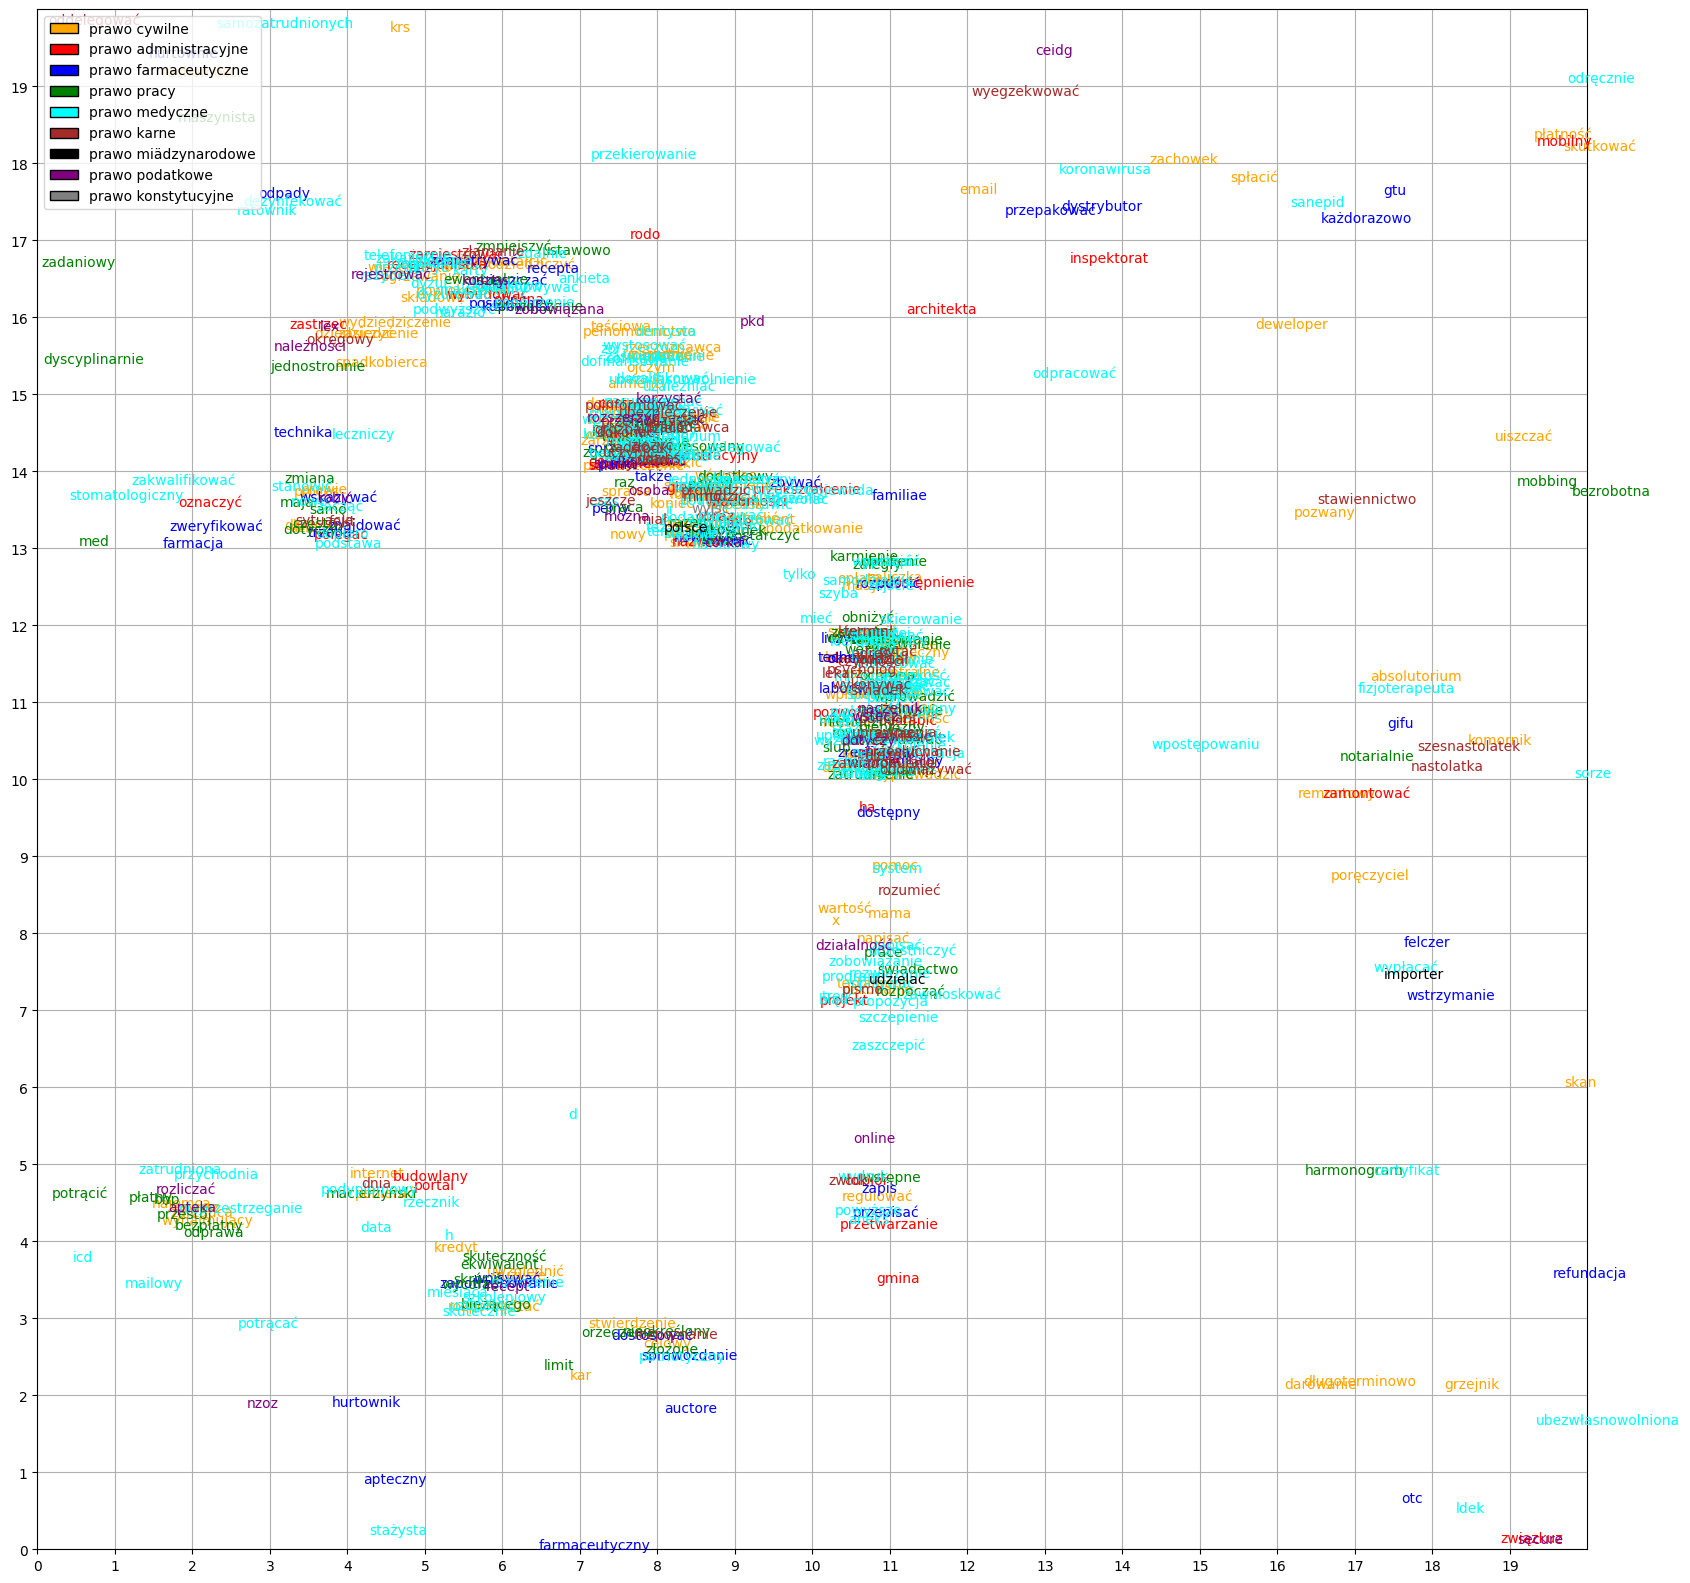

In [11]:
import ast
from matplotlib.patches import Patch
legend_elements = []
for index,color in enumerate(colors):
    c = list(colors.values())[index]
    l = list(colors.keys())[index]
    legend_elements.append(Patch(facecolor=c, edgecolor='black',label=l))
plt.figure(figsize=(20, 20))
texts = []
skippedWords = 0
allWords = 0
for index, affair in enumerate(data.keys()):
    words = ast.literal_eval(data[affair])
    words = clearListFromUselessWords(words)
    c = list(colors.values())[index]
    allWords += len(words)
    for word in words:
        try:
            vec = glove.get_vector(word)
            winnin_position = som.winner(vec)
            texts.append(plt.text((winnin_position[0]+np.random.rand()*.9)%map_dim, (winnin_position[1]+np.random.rand()*.9)%map_dim, word, color=c))
        except:
            skippedWords +=1
            
print("Did not find {}/{} words in the GloVe database, could not estimate it's vector".format(skippedWords,allWords))
plt.legend(handles=legend_elements, loc='upper left')
plt.xticks(range(map_dim))
plt.yticks(range(map_dim))
plt.grid()
plt.xlim([0, map_dim])
plt.ylim([0, map_dim])
plt.plot()